# Kaggle histopathology introduction
This notebook is an introduction to the data challenge of out of distribution classification of histopathology patches. It also serves as a baseline for the code and the model.

If you have any questions, feel free to contact me at [leo.fillioux@centralesupelec.fr](mailto:leo.fillioux@centralesupelec.fr).

In [1]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict


In [2]:
TRAIN_IMAGES_PATH = 'data/train.h5'
VAL_IMAGES_PATH = 'data/val.h5'
TEST_IMAGES_PATH = 'data/test.h5'
SEED = 0

In [3]:
torch.random.manual_seed(SEED)
random.seed(SEED)

## 1. Introduction to the data
The dataset consists of patches of whole slide images which should be classified into either containing tumor or not. The training images come from 3 different centers (i.e. hospitals), while the validation set comes from another center and the test set from yet another center. The visual aspect of the patches are quite different due to the slightly different staining procedures, conditions, and equipment from each hospital. The objective of the task is to build a classifier that is impacted by this distribution shift as little as possible.

The data is stored in `.h5` files, which can be seen as a folder hierarchy, which are can be seen as the following.
```
├── idx           # index of the image
│   └── img       # image in a tensor format
│   └── label     # binary label of the image
│   └── metadata  # some metadata on the images
```
The metadata is included for completeness but is not necessarily useful. The first element in the metadata corresponds to the center.

The following is a visualization of how different the images look from the different centers.

In [4]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [5]:
for img_data, data_path in zip([train_images, val_images], [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]):
    with h5py.File(data_path, 'r') as hdf:
        for img_idx in list(hdf.keys()):
            label = int(np.array(hdf.get(img_idx).get('label')))
            center = int(np.array(hdf.get(img_idx).get('metadata'))[0])
            if img_data[center][label] is None:
                img_data[center][label] = np.array(hdf.get(img_idx).get('img'))
            if all(all(value is not None for value in inner_dict.values()) for inner_dict in img_data.values()):
                break
all_data = {**train_images, **val_images}

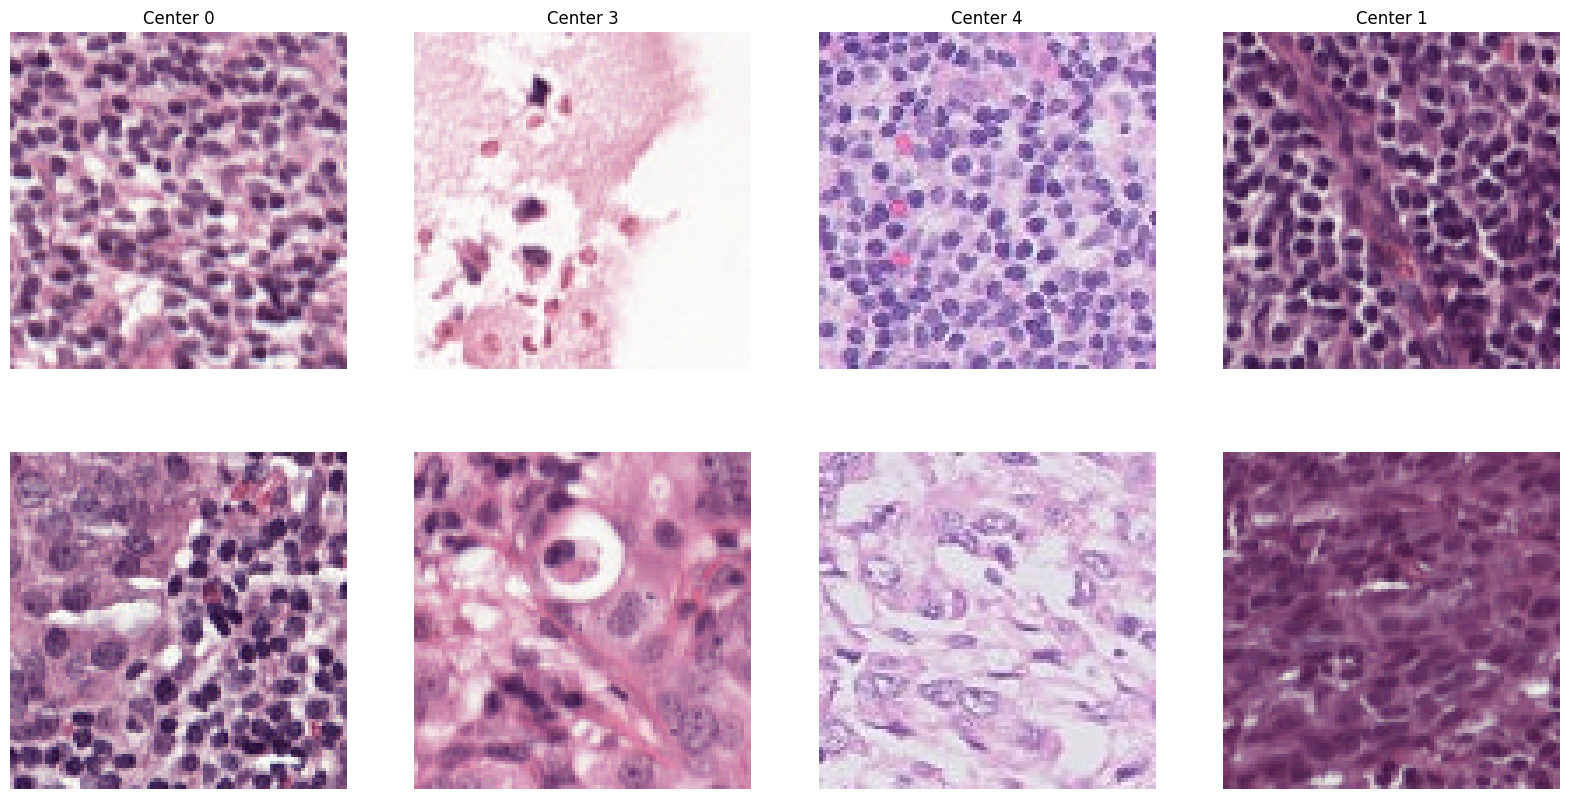

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        axs[label, center_ids[center]].imshow(np.moveaxis(all_data[center][label], 0, -1).astype(np.float32))
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

In [7]:
ALL_PATHS = [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]
samples = {}
max_per_class = 5

# Prépare les centres et labels attendus
expected_centers = [0, 1, 3, 4]  # tu peux adapter
expected_labels = [0, 1]
for center in expected_centers:
    for label in expected_labels:
        samples[(center, label)] = []

# Fonction pour vérifier si on a tout rempli
def all_samples_collected(samples, max_per_class):
    return all(len(samples[(c, l)]) >= max_per_class for c in expected_centers for l in expected_labels)

# Collecte
for path in ALL_PATHS:
    with h5py.File(path, 'r') as hdf:
        for img_idx in hdf.keys():
            label = int(np.array(hdf[img_idx]['label']))
            center = int(np.array(hdf[img_idx]['metadata'])[0])
            key = (center, label)
            if key in samples and len(samples[key]) < max_per_class:
                img = np.array(hdf[img_idx]['img'])
                samples[key].append(img)
            if all_samples_collected(samples, max_per_class):
                break


In [8]:
def plot_center_samples(center, samples, max_per_class=5):
    fig, axs = plt.subplots(2, max_per_class, figsize=(max_per_class * 3, 6))
    for label in [0, 1]:
        imgs = samples.get((center, label), [])
        for i in range(max_per_class):
            ax = axs[label, i]
            if i < len(imgs):
                img = np.moveaxis(imgs[i], 0, -1)
                ax.imshow(img.astype(np.float32))
                ax.set_title(f"Label {label}")
            ax.axis("off")
    plt.suptitle(f"Images du centre {center}", fontsize=16)
    plt.tight_layout()
    plt.show()

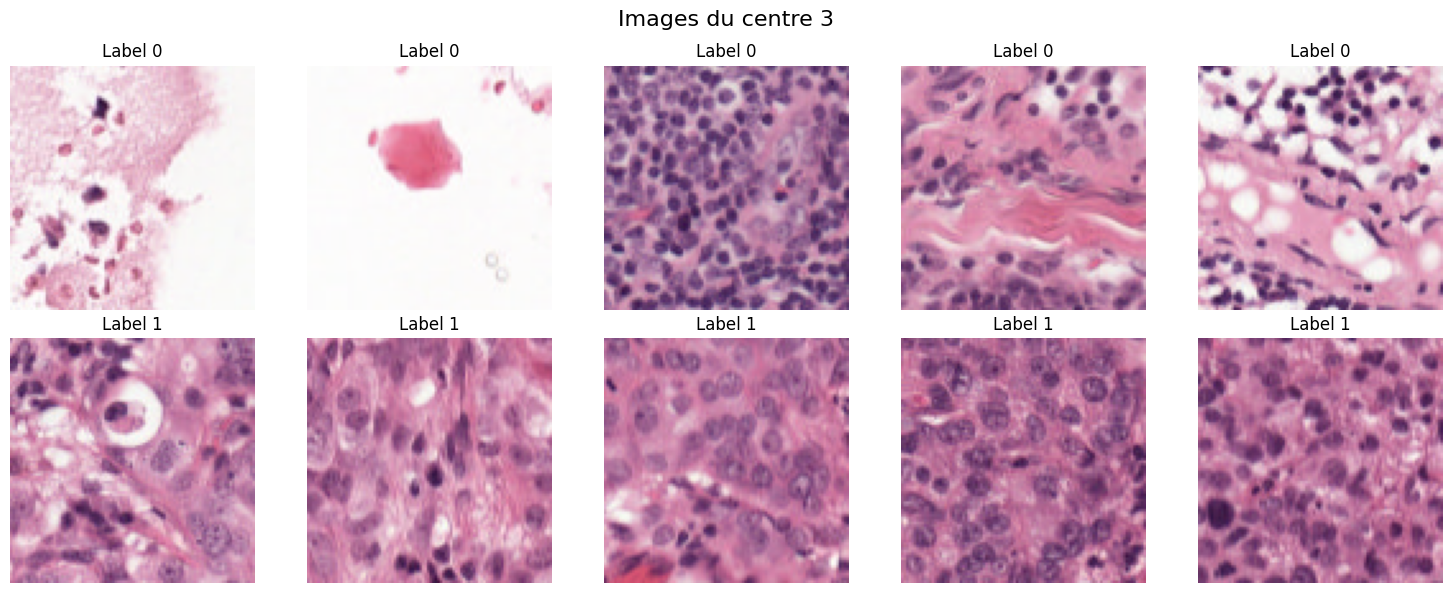

In [9]:
plot_center_samples(3, samples)

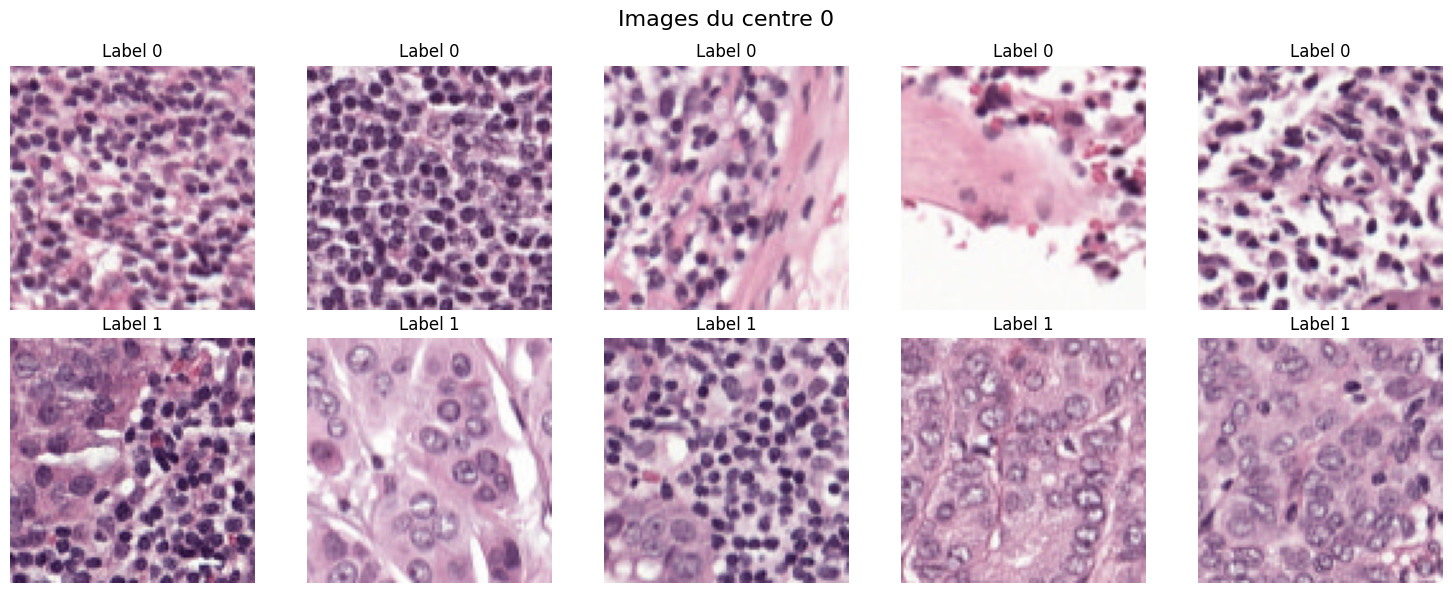

In [10]:
plot_center_samples(0, samples)

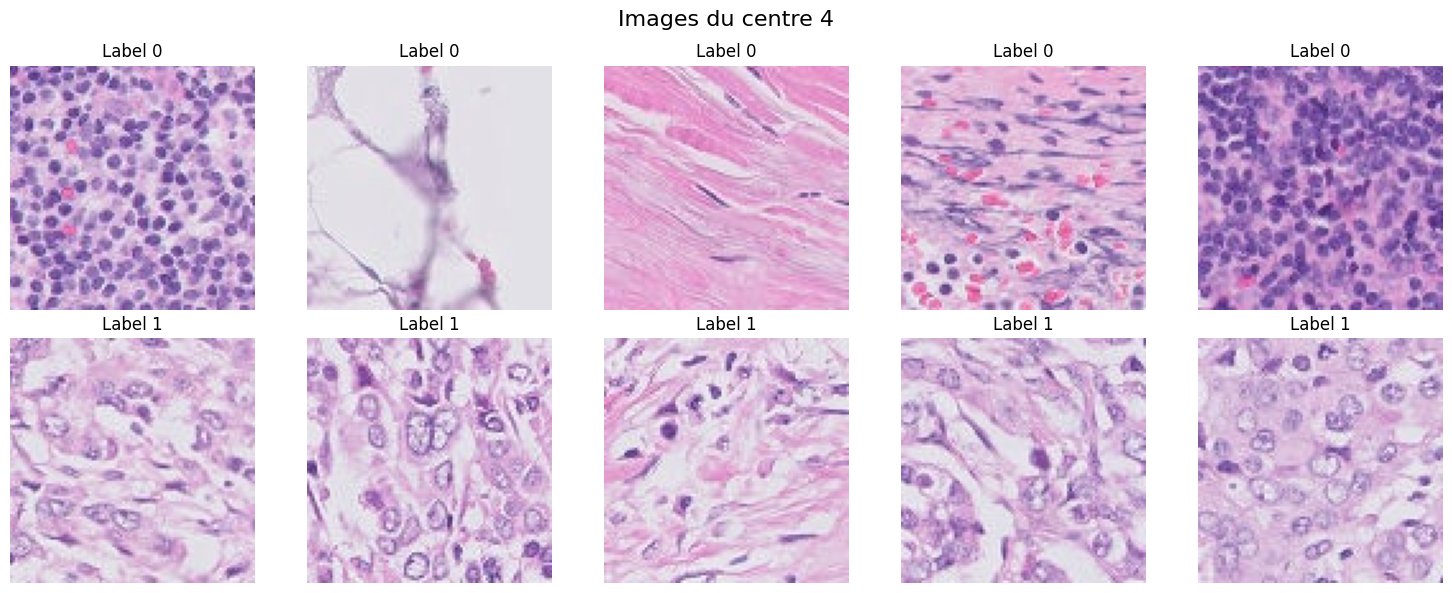

In [11]:
plot_center_samples(4, samples)

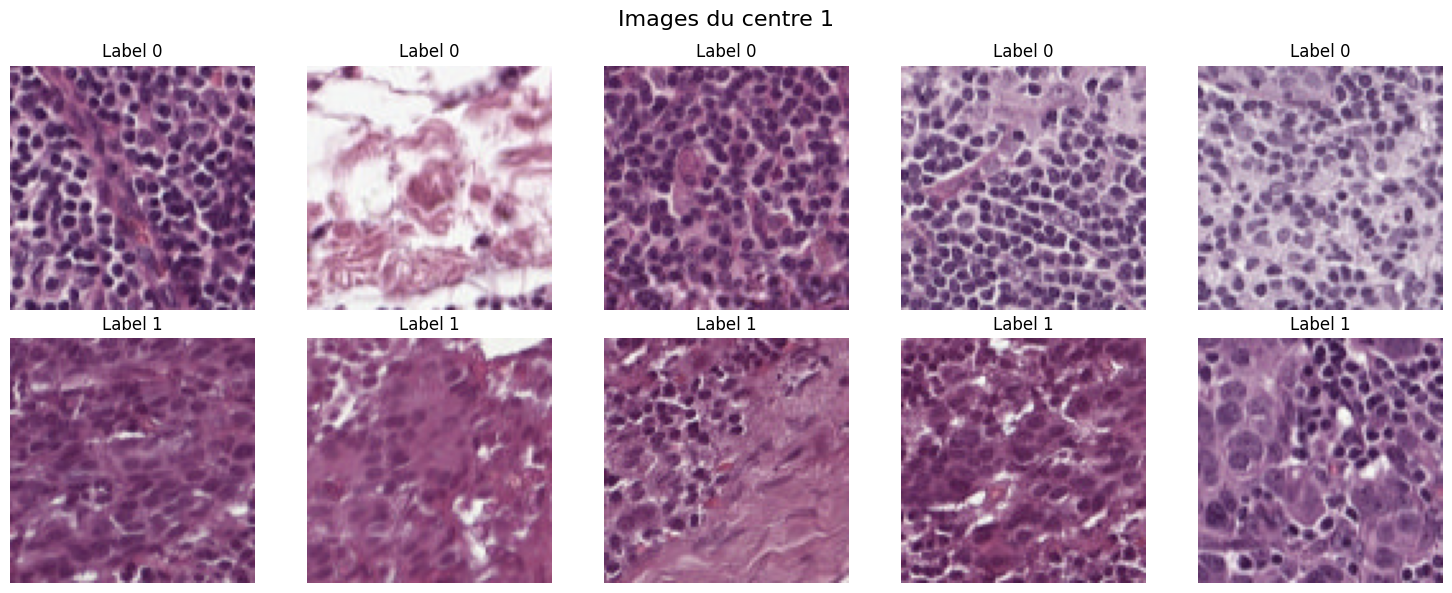

In [12]:
plot_center_samples(1, samples)

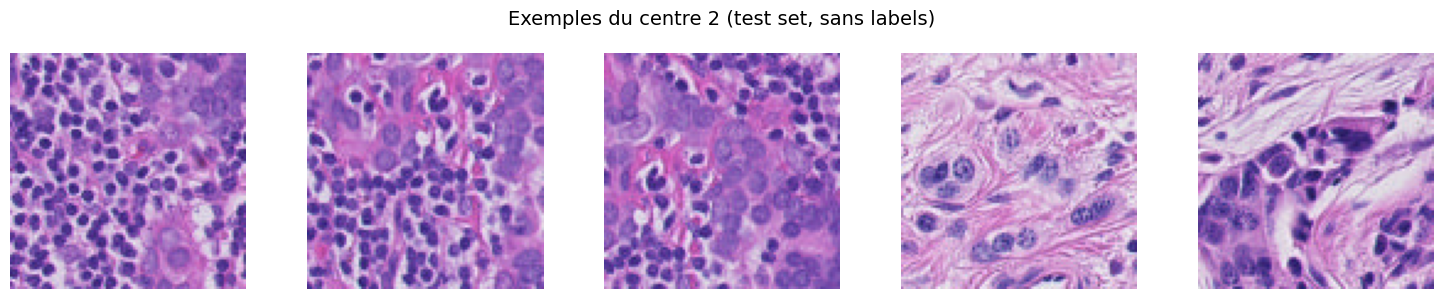

In [13]:
TEST_IMAGES_PATH = 'data/test.h5'
test_samples = []
max_images = 5

with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for img_idx in hdf.keys():
        img = np.array(hdf[img_idx]['img'])
        test_samples.append(img)
        if len(test_samples) == max_images:
            break

# Affichage
fig, axs = plt.subplots(1, max_images, figsize=(max_images * 3, 3))
for i, img in enumerate(test_samples):
    img = np.moveaxis(img, 0, -1)
    axs[i].imshow(img.astype(np.float32))
    axs[i].axis('off')
plt.suptitle("Exemples du centre 2 (test set, sans labels)", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
def count_images_by_center_and_label(h5_path):
    counts = defaultdict(int)
    with h5py.File(h5_path, 'r') as hdf:
        for img_id in hdf.keys():
            label = int(np.array(hdf[img_id]['label']))
            center = int(np.array(hdf[img_id]['metadata'])[0])
            counts[(center, label)] += 1
    return counts


In [15]:
train_counts = count_images_by_center_and_label(TRAIN_IMAGES_PATH)

# Affichage trié
for (center, label), count in sorted(train_counts.items()):
    print(f"Train : Centre {center} | Label {label} → {count} images")

Train : Centre 0 | Label 0 → 8815 images
Train : Centre 0 | Label 1 → 8941 images
Train : Centre 3 | Label 0 → 19293 images
Train : Centre 3 | Label 1 → 19463 images
Train : Centre 4 | Label 0 → 21672 images
Train : Centre 4 | Label 1 → 21816 images


In [16]:
val_counts = count_images_by_center_and_label(VAL_IMAGES_PATH)

# Affichage trié
for (center, label), count in sorted(val_counts.items()):
    print(f"Val : Centre {center} | Label {label} → {count} images")

Val : Centre 1 | Label 0 → 17452 images
Val : Centre 1 | Label 1 → 17452 images


In [18]:
import h5py
import torch

# Liste pour stocker les IDs des images aberrantes
list_aberrant_ids_train = []

# Charger les données du fichier h5 (train)
with h5py.File('data/train.h5', 'r') as f:
    img_ids = list(f.keys())  # Récupérer tous les IDs des images

    # Itérer sur toutes les images du train
    for img_id in img_ids:
        # Charger l'image
        img = torch.tensor(f[img_id]['img'][()]).float()


        # Vérifier si l'image contient des pixels à valeur 0 (aberrant)
        if (img == 0).sum().item() > 200:
            print(f"Aberrant image found at ID: {img_id} with 0s in the image {(img == 0).sum().item()}")
            list_aberrant_ids_train.append(img_id)

# Afficher les IDs des images aberrantes
print(f"Nombre d'images aberrantes: {len(list_aberrant_ids_train)}")

Aberrant image found at ID: 1008 with 0s in the image 12330
Aberrant image found at ID: 10405 with 0s in the image 16329
Aberrant image found at ID: 11003 with 0s in the image 20311
Aberrant image found at ID: 11227 with 0s in the image 12749
Aberrant image found at ID: 11249 with 0s in the image 18529
Aberrant image found at ID: 12613 with 0s in the image 15222
Aberrant image found at ID: 13024 with 0s in the image 13707
Aberrant image found at ID: 14027 with 0s in the image 14212
Aberrant image found at ID: 14308 with 0s in the image 14685
Aberrant image found at ID: 14368 with 0s in the image 14934
Aberrant image found at ID: 14588 with 0s in the image 14908
Aberrant image found at ID: 14610 with 0s in the image 1408
Aberrant image found at ID: 14762 with 0s in the image 13010
Aberrant image found at ID: 15163 with 0s in the image 16890
Aberrant image found at ID: 15363 with 0s in the image 13824
Aberrant image found at ID: 15473 with 0s in the image 15074
Aberrant image found at ID

In [19]:
# Liste pour stocker les IDs des images aberrantes
list_aberrant_ids_val = []

# Charger les données du fichier h5 (train)
with h5py.File('data/val.h5', 'r') as f:
    img_ids = list(f.keys())  # Récupérer tous les IDs des images

    # Itérer sur toutes les images du train
    for img_id in img_ids:
        # Charger l'image
        img = torch.tensor(f[img_id]['img'][()]).float()

        # Vérifier si l'image contient des pixels à valeur 0 (aberrant)
        if (img == 0).sum().item() > 200:
            print(f"Aberrant image found at ID: {img_id} with 0s in the image")
            list_aberrant_ids_val.append(img_id)

# Afficher les IDs des images aberrantes
print(f"Nombre d'images aberrantes: {len(list_aberrant_ids_val)}")

Aberrant image found at ID: 17692 with 0s in the image
Aberrant image found at ID: 17750 with 0s in the image
Aberrant image found at ID: 18180 with 0s in the image
Aberrant image found at ID: 18197 with 0s in the image
Aberrant image found at ID: 18275 with 0s in the image
Aberrant image found at ID: 18407 with 0s in the image
Aberrant image found at ID: 18914 with 0s in the image
Aberrant image found at ID: 19124 with 0s in the image
Aberrant image found at ID: 19187 with 0s in the image
Aberrant image found at ID: 19265 with 0s in the image
Aberrant image found at ID: 19397 with 0s in the image
Aberrant image found at ID: 19465 with 0s in the image
Aberrant image found at ID: 19583 with 0s in the image
Aberrant image found at ID: 19913 with 0s in the image
Aberrant image found at ID: 20185 with 0s in the image
Aberrant image found at ID: 20211 with 0s in the image
Aberrant image found at ID: 20237 with 0s in the image
Aberrant image found at ID: 20567 with 0s in the image
Aberrant i

In [47]:
len(list_aberrant_ids_train) + len(list_aberrant_ids_val)

473

In [22]:
from test_caille_CycleGAN import networks

# Charger le générateur G_A (A → B)
net_GA = networks.define_G(3, 3, 64, 'resnet_9blocks', 'instance',
                        True, "normal", 0.02, [0])
state_dict = torch.load(
    "content/kaggle-DL-MI/checkpoints/test_run_10_epochs_target_test/netG_A_epoch10.pth",
    map_location='cpu'
)


[INFO] No GPU available or --gpu_ids -1. Using CPU.
initialize network with normal


/var/folders/wf/j_xdxtjn4ks6rv3j5nj0kyvw0000gn/T/ipykernel_49344/1444534893.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [28]:
from collections import OrderedDict

# Retirer le préfixe 'module.' des clés du state_dict
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key = key.replace("module.", "")  # Supprimer "module." du nom de la clé
    new_state_dict[new_key] = value


net_GA.load_state_dict(new_state_dict)
net_GA.eval()  # Mode évaluation

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Dropout(p=0.5, inplace=False)
     

In [ ]:
from torchvision import transforms
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Liste des IDs d'images aberrantes (remplir avec vos IDs réels)
aberrant_train_ids = list_aberrant_ids_train  # IDs des images aberrantes du train
aberrant_val_ids = list_aberrant_ids_val  # IDs des images aberrantes du val

# Transformation (redimensionner à 98x98)
transform = None

class H5UnalignedDataset(Dataset):
    def __init__(self, h5_path, transform=None, aberrant_ids_train=None, aberrant_ids_val=None, net_GA=None, train=True):
        super().__init__()
        self.h5_path = h5_path
        self.transform = transform
        self.aberrant_ids_train = aberrant_ids_train or []  # Liste des images aberrantes à exclure
        self.aberrant_ids_val = aberrant_ids_val or []
        self.net_GA = net_GA  # Générateur pré-entrainé (net_GA)

        random.seed(42)

        # Charger les clés d'images
        with h5py.File(self.h5_path, 'r') as f:
            self.img_ids = list(f.keys())

        # Filtrer les images aberrantes
        if train:
            self.img_ids = [img_id for img_id in self.img_ids if img_id not in self.aberrant_ids_train]
        else:
            self.img_ids = [img_id for img_id in self.img_ids if img_id not in self.aberrant_ids_val]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        with h5py.File(self.h5_path, 'r') as f:
            img = torch.tensor(f[img_id]['img'][()]).float()
            label = np.array(f[img_id].get("label"))  # Extraire le label

        # Appliquer la transformation de redimensionnement si nécessaire
        if self.transform:
            img = self.transform(img)

        # Passer l'image à travers le générateur G_A pour transformer l'image
        if self.net_GA is not None:
            img = img.float() * 2.0 - 1.0
            img = self.net_GA(img.unsqueeze(0))  # Ajouter une dimension de batch
            img = (img + 1) / 2.0  # Rescale à [0, 1]

        return img.squeeze(0), label  # Retourner l'image transformée et le label

# Charger le dataset train et val en excluant les aberrants
train_dataset = H5UnalignedDataset(TRAIN_IMAGES_PATH, transform=transform, aberrant_ids_train=aberrant_train_ids, aberrant_ids_val=aberrant_val_ids, train=True, net_GA=net_GA)
val_dataset = H5UnalignedDataset(VAL_IMAGES_PATH, transform=transform, aberrant_ids_train=aberrant_train_ids, aberrant_ids_val=aberrant_val_ids, train=False, net_GA=net_GA)

# Créer les DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [49]:
len(train_dataset), len(val_dataset)

(99614, 34817)

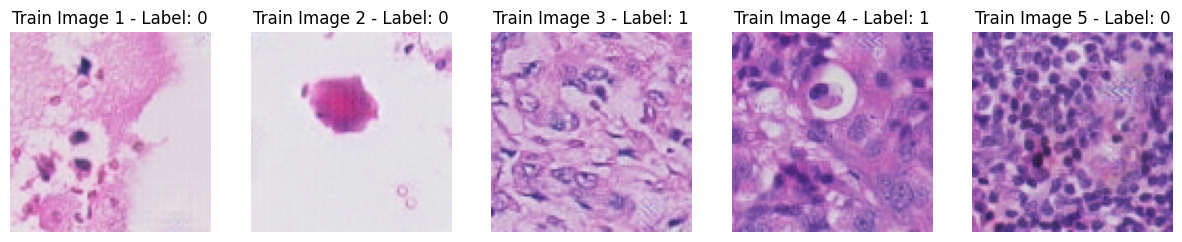

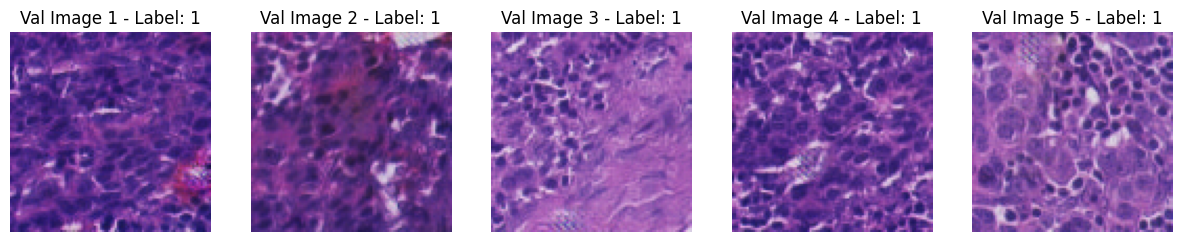

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_images_from_dataset(dataset, dataset_name="Train", num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Créer une figure avec plusieurs sous-graphes
    for i in range(num_images):
        img, label = dataset[i]  # Récupérer une image et son label

        # Convertir l'image tensor en numpy array pour l'affichage
        img = img.detach().cpu().numpy().transpose((1, 2, 0))

        # Afficher l'image sur l'axe correspondant
        axes[i].imshow(img)
        axes[i].set_title(f"{dataset_name} Image {i+1} - Label: {label}")
        axes[i].axis('off')  # Désactiver les axes

    plt.show()  # Afficher toutes les images à la fois

# Afficher quelques images du dataset train et val
show_images_from_dataset(train_dataset, "Train")
show_images_from_dataset(val_dataset, "Val")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm

device = "cpu"

transform = transforms.Compose([
    transforms.Resize((98, 98)),  # Convertir en tensor
])

dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)

# Geler toutes les couches sauf les deux dernières
for name, param in dino_model.named_parameters():
    if not ("blocks.10" in name or "blocks.11" in name or "norm" in name or "head" in name):
        param.requires_grad = False

class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # Dernière couche
        x = self.sigmoid(x)  # Activation sigmoïde pour la probabilité
        return x.view(-1)  # Assurer que la sortie a la forme correcte (batch_size,)

feature_dim = 384

# Définir le classificateur
classifier = Classifier(input_size=feature_dim, output_size=1).to(device)

# Optimiseur avec DINO + classifieur
params_to_optimize = list(filter(lambda p: p.requires_grad, dino_model.parameters())) + list(classifier.parameters())
optimizer = optim.Adam(params_to_optimize, lr=1e-4)
criterion = nn.BCELoss()
accuracy_metric = BinaryAccuracy().to(device)

# Boucle d'entraînement
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    dino_model.train()
    classifier.train()
    total_loss, total_acc = 0, 0

    for imgs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        imgs, labels = imgs.to(device), labels.float().to(device)

        imgs = transform(imgs)

        # Passer par DINO puis le classifieur
        features = dino_model(imgs)
        preds = classifier(features)

        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy_metric(preds > 0.5, labels.int())
        total_loss += loss.item() * imgs.size(0)
        total_acc += acc.item() * imgs.size(0)

    avg_loss = total_loss / len(train_dataloader.dataset)
    avg_acc = total_acc / len(train_dataloader.dataset)
    print(f"Train Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

    # Évaluation
    dino_model.eval()
    classifier.eval()
    val_loss, val_acc = 0, 0

    with torch.no_grad():
        for imgs, labels in val_dataloader:
            imgs, labels = imgs.to(device), labels.float().to(device)
            features = dino_model(imgs)
            preds = classifier(features)

            loss = criterion(preds, labels)
            acc = accuracy_metric(preds > 0.5, labels.int())

            val_loss += loss.item() * imgs.size(0)
            val_acc += acc.item() * imgs.size(0)

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)
    print(f"Val Loss: {avg_val_loss:.4f} | Accuracy: {avg_val_acc:.4f}")


[Parameter containing:
tensor([0.7170, 1.9692, 0.6892, 1.1879, 1.3580, 0.8712, 1.5161, 1.5370, 1.0514,
        1.2583, 0.9482, 0.8902, 1.0606, 0.7713, 1.2514, 1.3423, 1.4648, 1.5103,
        0.5118, 1.4618, 0.9387, 0.1656, 0.8773, 3.1409, 1.2563, 0.6395, 0.6567,
        1.4711, 1.8434, 0.7514, 1.3705, 1.4808, 1.3880, 1.0769, 1.1688, 1.3052,
        1.1968, 1.3662, 1.3270, 1.6550, 1.1798, 0.5585, 1.3256, 1.0693, 3.6385,
        1.6240, 1.2219, 1.3757, 1.3965, 0.5534, 0.9965, 1.6619, 1.4619, 1.1659,
        1.4953, 0.8497, 1.7270, 1.3068, 1.2922, 1.6473, 1.4183, 0.6967, 1.2287,
        1.8910, 0.8069, 0.9894, 0.7825, 1.6119, 1.3979, 1.3328, 0.6568, 1.0828,
        1.6002, 1.1154, 0.6038, 1.1679, 1.6010, 1.0887, 1.5420, 1.5354, 1.4189,
        0.7557, 0.9353, 0.9432, 1.8309, 0.9105, 0.7713, 0.8608, 0.8825, 0.7711,
        0.9983, 1.1636, 0.9524, 1.6911, 1.3730, 0.8917, 0.6002, 1.1385, 0.8814,
        0.6948, 0.9245, 0.8361, 0.7309, 1.3485, 0.6819, 1.3252, 0.5215, 1.3037,
        1.5084, 0

Epoch 1/10:   0%|          | 1/3113 [00:08<7:36:40,  8.80s/it]


KeyboardInterrupt: 

In [ ]:


class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # Dernière couche
        x = self.sigmoid(x)  # Activation sigmoïde pour la probabilité
        return x.view(-1)  # Assurer que la sortie a la forme correcte (batch_size,)


## 2. Building a baseline model
The baseline model consists of extracting DINOv2 embeddings and linear probing.

In [17]:
BATCH_SIZE = 16

### 2.1. Baseline dataset
We start by creating the model to read and process the data. For this simple model we also use another dataset with the preprocessed embeddings to avoid recomputing the same embeddings each time.

In [63]:
class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode

        with h5py.File(self.dataset_path, 'r') as hdf:
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(hdf.get(img_id).get('img'))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else None
        print(img.shape)
        print(self.preprocessing(img).shape)
        return self.preprocessing(img).float(), label

In [58]:
def precompute(dataloader, model, device):
    xs, ys = [], []
    for x, y in tqdm(dataloader, leave=False):
        with torch.no_grad():
            xs.append(model(x.to(device)).detach().cpu().numpy())
        ys.append(y.numpy())
    xs = np.vstack(xs)
    ys = np.hstack(ys)
    return torch.tensor(xs), torch.tensor(ys)

In [59]:
class PrecomputedDataset(Dataset):
    def __init__(self, features, labels):
        super(PrecomputedDataset, self).__init__()
        self.features = features
        self.labels = labels.unsqueeze(-1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].float()

In [64]:
preprocessing = transforms.Resize((98, 98))
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, preprocessing, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, preprocessing, 'train')

In [65]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
train_dataloader_cycle_GAN = DataLoader(train_dataset, shuffle=False, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

### 2.1.2 Cycle GAN normalizaiton

In [66]:
next(iter(train_dataloader))

torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])
torch.Size([3, 96, 96])
torch.Size([3, 98, 98])


[tensor([[[[0.6118, 0.6802, 0.7788,  ..., 0.8164, 0.8242, 0.8433],
           [0.6230, 0.7100, 0.8057,  ..., 0.8115, 0.8120, 0.8169],
           [0.6421, 0.7510, 0.8301,  ..., 0.7891, 0.7822, 0.7896],
           ...,
           [0.5576, 0.5732, 0.6406,  ..., 0.6792, 0.7349, 0.7402],
           [0.5737, 0.5967, 0.6675,  ..., 0.6372, 0.6899, 0.7202],
           [0.6001, 0.6304, 0.6987,  ..., 0.6099, 0.6440, 0.6782]],
 
          [[0.3647, 0.4143, 0.5161,  ..., 0.5059, 0.5068, 0.5371],
           [0.3914, 0.4553, 0.5327,  ..., 0.4832, 0.4836, 0.4993],
           [0.4219, 0.4937, 0.5527,  ..., 0.4526, 0.4568, 0.4758],
           ...,
           [0.2910, 0.2954, 0.3584,  ..., 0.3894, 0.4373, 0.4380],
           [0.3064, 0.3220, 0.3779,  ..., 0.3621, 0.3994, 0.4153],
           [0.3254, 0.3560, 0.3940,  ..., 0.3389, 0.3694, 0.3960]],
 
          [[0.5488, 0.5874, 0.6738,  ..., 0.6470, 0.6436, 0.6665],
           [0.5757, 0.6172, 0.6865,  ..., 0.6392, 0.6357, 0.6436],
           [0.5913, 0.63

### 2.2. Building the models and precomputing the features

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

Working on cpu.


In [26]:
feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
feature_extractor.eval()
linear_probing = torch.nn.Sequential(torch.nn.Linear(feature_extractor.num_features, 1),
                                     torch.nn.Sigmoid()).to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /Users/many/.cache/torch/hub/main.zip
/Users/many/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/many/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/many/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /Users/many/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:05<00:00, 15.7MB/s]


In [27]:
train_dataset = PrecomputedDataset(*precompute(train_dataloader, feature_extractor, device))
val_dataset = PrecomputedDataset(*precompute(val_dataloader, feature_extractor, device))

  0%|          | 0/6250 [00:00<?, ?it/s]

/var/folders/wf/j_xdxtjn4ks6rv3j5nj0kyvw0000gn/T/ipykernel_98571/1650232611.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  img = torch.tensor(hdf.get(img_id).get('img'))


KeyboardInterrupt: 

In [16]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

## 3. Training the model

In [17]:
OPTIMIZER = 'Adam'
OPTIMIZER_PARAMS = {'lr': 0.001}
LOSS = 'BCELoss'
METRIC = 'Accuracy'
NUM_EPOCHS = 100
PATIENCE = 10

In [18]:
optimizer = getattr(torch.optim, OPTIMIZER)(linear_probing.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(torch.nn, LOSS)()
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

In [19]:
for epoch in range(NUM_EPOCHS):
    linear_probing.train()
    train_metrics, train_losses = [], []
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        train_pred = linear_probing(train_x.to(device))
        loss = criterion(train_pred, train_y.to(device))
        loss.backward()
        optimizer.step()
        train_losses.extend([loss.item()]*len(train_y))
        train_metric = metric(train_pred.cpu(), train_y.int().cpu())
        train_metrics.extend([train_metric.item()]*len(train_y))
    print(f'Epoch train [{epoch+1}/{NUM_EPOCHS}] | Loss {np.mean(train_losses):.4f} | Metric {np.mean(train_metrics):.4f}')

    linear_probing.eval()
    val_metrics, val_losses = [], []
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = linear_probing(val_x.to(device))
        loss = criterion(val_pred, val_y.to(device))
        val_losses.extend([loss.item()]*len(val_y))
        val_metric = metric(val_pred.cpu(), val_y.int().cpu())
        val_metrics.extend([val_metric.item()]*len(val_y))
    print(f'Epoch valid [{epoch+1}/{NUM_EPOCHS}] | Loss {np.mean(val_losses):.4f} | Metric {np.mean(val_metrics):.4f}')

    if np.mean(val_losses) < min_loss:
        mean_val_loss = np.mean(val_losses)
        print(f'New best loss {min_loss:.4f} -> {mean_val_loss:.4f}')
        min_loss = mean_val_loss
        best_epoch = epoch
        torch.save(linear_probing.state_dict(), 'best_model.pth')

    if epoch - best_epoch == PATIENCE:
        break

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [1/100] | Loss 0.1759 | Metric 0.9331


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [1/100] | Loss 0.3392 | Metric 0.8584
New best loss inf -> 0.3392


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [2/100] | Loss 0.1551 | Metric 0.9415


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [2/100] | Loss 0.3700 | Metric 0.8543


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [3/100] | Loss 0.1506 | Metric 0.9435


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [3/100] | Loss 0.3396 | Metric 0.8626


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [4/100] | Loss 0.1481 | Metric 0.9444


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [4/100] | Loss 0.3574 | Metric 0.8626


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [5/100] | Loss 0.1472 | Metric 0.9445


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [5/100] | Loss 0.3248 | Metric 0.8706
New best loss 0.3392 -> 0.3248


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [6/100] | Loss 0.1454 | Metric 0.9459


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [6/100] | Loss 0.3279 | Metric 0.8742


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [7/100] | Loss 0.1446 | Metric 0.9457


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [7/100] | Loss 0.3619 | Metric 0.8643


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [8/100] | Loss 0.1446 | Metric 0.9458


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [8/100] | Loss 0.3741 | Metric 0.8612


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [9/100] | Loss 0.1445 | Metric 0.9458


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [9/100] | Loss 0.3524 | Metric 0.8668


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [10/100] | Loss 0.1439 | Metric 0.9462


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [10/100] | Loss 0.3956 | Metric 0.8500


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [11/100] | Loss 0.1437 | Metric 0.9462


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [11/100] | Loss 0.3128 | Metric 0.8786
New best loss 0.3248 -> 0.3128


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [12/100] | Loss 0.1438 | Metric 0.9465


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [12/100] | Loss 0.3371 | Metric 0.8744


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [13/100] | Loss 0.1421 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [13/100] | Loss 0.3473 | Metric 0.8707


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [14/100] | Loss 0.1428 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [14/100] | Loss 0.3405 | Metric 0.8720


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [15/100] | Loss 0.1436 | Metric 0.9461


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [15/100] | Loss 0.3406 | Metric 0.8657


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [16/100] | Loss 0.1424 | Metric 0.9473


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [16/100] | Loss 0.3429 | Metric 0.8730


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [17/100] | Loss 0.1425 | Metric 0.9467


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [17/100] | Loss 0.3589 | Metric 0.8698


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [18/100] | Loss 0.1422 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [18/100] | Loss 0.3176 | Metric 0.8782


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [19/100] | Loss 0.1431 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [19/100] | Loss 0.3470 | Metric 0.8709


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [20/100] | Loss 0.1435 | Metric 0.9467


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [20/100] | Loss 0.3122 | Metric 0.8809
New best loss 0.3128 -> 0.3122


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [21/100] | Loss 0.1430 | Metric 0.9466


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [21/100] | Loss 0.3466 | Metric 0.8698


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [22/100] | Loss 0.1423 | Metric 0.9465


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [22/100] | Loss 0.3355 | Metric 0.8726


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [23/100] | Loss 0.1419 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [23/100] | Loss 0.3313 | Metric 0.8731


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [24/100] | Loss 0.1420 | Metric 0.9468


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [24/100] | Loss 0.3296 | Metric 0.8801


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [25/100] | Loss 0.1418 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [25/100] | Loss 0.3178 | Metric 0.8780


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [26/100] | Loss 0.1430 | Metric 0.9468


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [26/100] | Loss 0.3324 | Metric 0.8711


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [27/100] | Loss 0.1427 | Metric 0.9461


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [27/100] | Loss 0.3186 | Metric 0.8774


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [28/100] | Loss 0.1425 | Metric 0.9475


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [28/100] | Loss 0.4484 | Metric 0.8364


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [29/100] | Loss 0.1420 | Metric 0.9470


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [29/100] | Loss 0.3287 | Metric 0.8778


  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch train [30/100] | Loss 0.1422 | Metric 0.9469


  0%|          | 0/2182 [00:00<?, ?it/s]

Epoch valid [30/100] | Loss 0.3383 | Metric 0.8745


## 4. Making the final prediction

To create a solutions file, you need to generate a CSV with 2 columns.
- **ID**: containing the ID of the image
- **Pred**: with the predicted class (**threshold the prediction to get either 0 or 1**)

In [20]:
linear_probing.load_state_dict(torch.load('best_model.pth', weights_only=True))
linear_probing.eval()
linear_probing.to(device)
prediction_dict = {}

In [21]:
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    test_ids = list(hdf.keys())

In [25]:
solutions_data = {'ID': [], 'Pred': []}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for test_id in tqdm(test_ids):
        img = preprocessing(torch.tensor(np.array(hdf.get(test_id).get('img')))).unsqueeze(0).float()
        pred = linear_probing(feature_extractor(img.to(device))).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(pred.item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv('baseline.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]